In [1]:
## import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
# Import all functions from pyspark.sql.functions, including col etc to manipulate columns
from pyspark.sql.functions import *
# Vector Assembler
from pyspark.ml.feature import VectorAssembler
# Linear Regression Analysis
from pyspark.ml.regression import LinearRegression
# Standardisation
from pyspark.ml.feature import StandardScaler
# StringIndexer
from pyspark.ml.feature import *
# RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
!hdfs dfs -put /home/master/Downloads/LC

In [3]:
!hdfs dfs -ls LC

Found 4 items
-rw-r--r--   1 master supergroup   48669611 2019-02-15 19:28 LC/LoanStats_2017Q1.csv
-rw-r--r--   1 master supergroup   53047611 2019-02-15 19:28 LC/LoanStats_2017Q2.csv
-rw-r--r--   1 master supergroup   61960082 2019-02-15 19:28 LC/LoanStats_2017Q3.csv
-rw-r--r--   1 master supergroup   59676775 2019-02-15 19:28 LC/LoanStats_2017Q4.csv


In [2]:
loans = spark.read.format("com.databricks.spark.csv")\
.option("header", "true")\
.option("inferSchema", "true").\
load(["hdfs://localhost:8020/user/master/LC/LoanStats_2017Q1.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q2.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q3.csv",
     "hdfs://localhost:8020/user/master/LC/LoanStats_2017Q4.csv"])

In [3]:
# type
type(loans)

pyspark.sql.dataframe.DataFrame

In [3]:
loans.count()

443080

In [6]:
# in-memory-usage
loans.cache()

DataFrame[id: string, member_id: string, loan_amnt: string, funded_amnt: string, funded_amnt_inv: string, term: string, int_rate: string, installment: string, grade: string, sub_grade: string, emp_title: string, emp_length: string, home_ownership: string, annual_inc: string, verification_status: string, issue_d: string, loan_status: string, pymnt_plan: string, url: string, desc: string, purpose: string, title: string, zip_code: string, addr_state: string, dti: string, delinq_2yrs: string, earliest_cr_line: string, inq_last_6mths: string, mths_since_last_delinq: string, mths_since_last_record: string, open_acc: string, pub_rec: string, revol_bal: string, revol_util: string, total_acc: string, initial_list_status: string, out_prncp: string, out_prncp_inv: string, total_pymnt: string, total_pymnt_inv: string, total_rec_prncp: string, total_rec_int: string, total_rec_late_fee: string, recoveries: string, collection_recovery_fee: string, last_pymnt_d: string, last_pymnt_amnt: string, next_p

In [3]:
loans.createOrReplaceTempView("loans")

In [8]:
spark.sql("SELECT * FROM loans LIMIT 1").show(n=1)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+---

In [21]:
spark.sql("SELECT * FROM loans LIMIT 5").toPandas().head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term;,_c145,_c146,_c147
0,None,None,16000,16000,16000,60,12.74,361.93,C,C1,...,N,None,None,None,None,None,;,None,None,None
1,None,None,11875,11875,11875,36,11.44,391.26,B,B4,...,N,None,None,None,None,None,;,None,None,None
2,None,None,12000,12000,12000,36,7.99,375.99,A,A5,...,N,None,None,None,None,None,;,None,None,None
3,None,None,25000,25000,25000,36,15.99,878.81,C,C5,...,N,None,None,None,None,None,;,None,None,None
4,None,None,1500,1500,1500,36,5.32,45.18,A,A1,...,N,None,None,None,None,None,;,None,None,None


In [4]:
loans_a = loans['int_rate','loan_amnt','term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc','verification_status','purpose','addr_state', 'open_acc']

In [5]:
loans_a = loans_a.withColumn("loan_amnt", loans_a["loan_amnt"].cast(IntegerType()))
loans_a = loans_a.withColumn("term", loans_a["term"].cast(IntegerType()))
loans_a = loans_a.withColumn("emp_length", loans_a["emp_length"].cast(IntegerType()))
loans_a = loans_a.withColumn("annual_inc", loans_a["annual_inc"].cast(IntegerType()))
loans_a = loans_a.withColumn("open_acc", loans_a["open_acc"].cast(IntegerType()))
loans_a = loans_a.withColumn("int_rate", loans_a["int_rate"].cast(IntegerType()))

In [11]:
loans_a.toPandas().head(5)

,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,20,2800,36,D,D4,0,MORTGAGE,1,Not Verified,debt_consolidation,PA,13
1,10,11000,36,B,B4,0,MORTGAGE,1,Not Verified,debt_consolidation,FL,14
2,24,19200,60,E,E3,0,MORTGAGE,1,Not Verified,debt_consolidation,IN,11
3,19,25000,60,D,D3,0,MORTGAGE,1,Not Verified,debt_consolidation,PA,13
4,7,20000,36,A,A4,0,RENT,1,Not Verified,debt_consolidation,NY,8


In [12]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)



In [13]:
#missing value analysis
loans_a_pd = loans_a.toPandas()
loans_a_pd.isnull().sum()

int_rate               0
loan_amnt              0
term                   0
grade                  0
sub_grade              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
purpose                0
addr_state             0
open_acc               0
dtype: int64

In [14]:
# descriptive stats on the data
loans_a.describe().toPandas()

,summary,int_rate,loan_amnt,term,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,count,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080,443080
1,mean,12.718466191207005,14841.138676988354,42.66050374650176,None,None,5.483576329331046,None,80194.4396610093,None,None,None,11.62047937167103
2,stddev,5.203642966740987,9630.427292613873,10.746629258128982,None,None,3.8227612307124237,None,204202.90394065322,None,None,None,5.789256580291201
3,min,5,1000,36,A,A1,0,ANY,0,Not Verified,car,AK,0
4,max,30,40000,60,G,G5,10,RENT,110000000,Verified,wedding,WY,93


In [6]:
# Transform and add to df
loans_a = loans_a.withColumn('loan_amnt_tsd', col('loan_amnt')/1000)
loans_a = loans_a.withColumn('annual_inc_tsd', col('annual_inc')/1000)

In [7]:
# z-Standardisation
loans_a = loans_a.withColumn('loan_amnt_zstand', (col('loan_amnt')-14841.13)/9630.42)
loans_a = loans_a.withColumn('annual_inc_zstand', (col('annual_inc')-80194.43)/204202.90)

In [8]:
loans_a.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- loan_amnt_tsd: double (nullable = true)
 |-- annual_inc_tsd: double (nullable = true)
 |-- loan_amnt_zstand: double (nullable = true)
 |-- annual_inc_zstand: double (nullable = true)



In [8]:
# TempView
loans_a.createOrReplaceTempView("loans_a")

In [9]:
loans_b = spark.sql("SELECT int_rate, LOG(loan_amnt_tsd) AS loan_amnt_ln, LOG(annual_inc_tsd) AS annual_inc_ln, \
                       emp_length, grade, sub_grade, home_ownership, verification_status, purpose, addr_state, \
                       open_acc, term FROM loans_a")

In [10]:
loans_b.cache()

DataFrame[int_rate: int, loan_amnt_ln: double, annual_inc_ln: double, emp_length: int, grade: string, sub_grade: string, home_ownership: string, verification_status: string, purpose: string, addr_state: string, open_acc: int, term: int]

In [11]:
loans_b.createOrReplaceTempView("loans_b")

In [28]:
loans_b.toPandas().head(3)

,int_rate,loan_amnt_ln,annual_inc_ln,emp_length,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,open_acc,term
0,20,1.029619,-6.907755,0,D,D4,MORTGAGE,Not Verified,debt_consolidation,PA,13,36
1,10,2.397895,-6.907755,0,B,B4,MORTGAGE,Not Verified,debt_consolidation,FL,14,36
2,24,2.954910,-6.907755,0,E,E3,MORTGAGE,Not Verified,debt_consolidation,IN,11,60


In [12]:
stringIndexer = StringIndexer(inputCol='home_ownership', outputCol='home_ownership_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='verification_status', outputCol='verification_status_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

## ADDR_STATE REMOVED FROM MODELING DUE TO SYSTEM CRASH
#stringIndexer = StringIndexer(inputCol='addr_state', outputCol='addr_state_num')
#model = stringIndexer.fit(loans_b)
#loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='purpose', outputCol='purpose_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='grade', outputCol='grade_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

stringIndexer = StringIndexer(inputCol='sub_grade', outputCol='sub_grade_num')
model = stringIndexer.fit(loans_b)
loans_b = model.transform(loans_b)

#loans_b.toPandas().head(5)

In [13]:
# setup OneHotEncoder
encoder = OneHotEncoder(inputCol='home_ownership_num', outputCol='home_ownership_cat') # dropLast = False
# apply to data
loans_b = encoder.transform(loans_b)


encoder = OneHotEncoder(inputCol='verification_status_num', outputCol='verification_status_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

## ADDR_STATE REMOVED FROM MODELING DUE TO SYSTEM CRASH
#encoder = OneHotEncoder(inputCol='addr_state_num', outputCol='addr_state_cat') # dropLast = False
#loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='purpose_num', outputCol='purpose_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='grade_num', outputCol='grade_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

encoder = OneHotEncoder(inputCol='sub_grade_num', outputCol='sub_grade_cat') # dropLast = False
loans_b = encoder.transform(loans_b)

loans_b.toPandas().head(5)

,int_rate,loan_amnt_ln,annual_inc_ln,emp_length,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,...,home_ownership_num,verification_status_num,purpose_num,grade_num,sub_grade_num,home_ownership_cat,verification_status_cat,purpose_cat,grade_cat,sub_grade_cat
0,20,1.029619,-6.907755,0,D,D4,MORTGAGE,Not Verified,debt_consolidation,PA,...,0.0,1.0,0.0,3.0,18.0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10,2.397895,-6.907755,0,B,B4,MORTGAGE,Not Verified,debt_consolidation,FL,...,0.0,1.0,0.0,1.0,9.0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,24,2.954910,-6.907755,0,E,E3,MORTGAGE,Not Verified,debt_consolidation,IN,...,0.0,1.0,0.0,4.0,23.0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,19,3.218876,-6.907755,0,D,D3,MORTGAGE,Not Verified,debt_consolidation,PA,...,0.0,1.0,0.0,3.0,16.0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7,2.995732,-6.907755,0,A,A4,RENT,Not Verified,debt_consolidation,NY,...,1.0,1.0,0.0,2.0,12.0,"(0.0, 1.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
# Initalize
vectorAssembler = VectorAssembler(inputCols = ['loan_amnt_ln','term', 'grade_cat', 'sub_grade_cat', 'emp_length', \
                                               'home_ownership_cat', 'annual_inc_ln','verification_status_cat', \
                                               'purpose_cat', 'open_acc'], 
                                  outputCol = 'features')
loans_b_ml = vectorAssembler.setHandleInvalid("skip").transform(loans_b)
loans_b_ml.printSchema()

root
 |-- int_rate: integer (nullable = true)
 |-- loan_amnt_ln: double (nullable = true)
 |-- annual_inc_ln: double (nullable = true)
 |-- emp_length: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- home_ownership_num: double (nullable = false)
 |-- verification_status_num: double (nullable = false)
 |-- purpose_num: double (nullable = false)
 |-- grade_num: double (nullable = false)
 |-- sub_grade_num: double (nullable = false)
 |-- home_ownership_cat: vector (nullable = true)
 |-- verification_status_cat: vector (nullable = true)
 |-- purpose_cat: vector (nullable = true)
 |-- grade_cat: vector (nullable = true)
 |-- sub_grade_cat: vector (nullable = true)
 |-- features: 

In [16]:
loans_b_mll = loans_b_ml.select('features','int_rate')
loans_b_mll.toPandas().head(5)

,features,int_rate
0,"(1.0296194171811581, 36.0, 0.0, 0.0, 0.0, 1.0,...",20
1,"(2.3978952727983707, 36.0, 0.0, 1.0, 0.0, 0.0,...",10
2,"(2.954910279033736, 60.0, 0.0, 0.0, 0.0, 0.0, ...",24
3,"(3.2188758248682006, 60.0, 0.0, 0.0, 0.0, 1.0,...",19
4,"(2.995732273553991, 36.0, 0.0, 0.0, 1.0, 0.0, ...",7


In [17]:
training_data, test_data = loans_b_mll.randomSplit(weights=[.7,.3], seed=25)

In [18]:
training_data.count()

310071

In [19]:
test_data.count()

133008

In [20]:
#Step 1: Initialize the linear regression
lr_cat = LinearRegression(labelCol="int_rate", 
                          maxIter=1E4, 
                          regParam=.0, 
                          elasticNetParam=.0, 
                          featuresCol='features')
# Parametrization for a classical linear regression

In [21]:
linearModel_cat = lr_cat.fit(training_data)

In [22]:
linearModel_cat.coefficients

DenseVector([-0.0156, 0.0018, -9.4197, -11.4961, -12.6922, -6.1202, -3.0461, -0.4263, -8.5723, -7.4902, -4.8848, -5.9118, -9.8124, -6.8966, -7.5719, -8.2257, -9.2355, -8.1517, -10.2907, -12.2893, -10.2886, -10.5132, -7.3416, -10.7598, -5.1985, -6.1709, -4.1297, -2.8797, -3.9597, -0.9644, -4.942, -2.9581, -1.9653, -1.5751, 0.0554, -0.5693, 0.3987, 0.3914, 0.001, 0.0088, -0.0, -0.0578, -0.0005, 0.0034, -0.0002, 0.0022, -0.1541, 0.0037, 0.0038, 0.0174, -0.0342, -0.0383, -0.035, -0.0352, -0.0229, -0.0301, -0.0313, -0.0523, -0.0261, -0.0218, -0.0172, -0.0079, -0.0162, -0.0004])

In [23]:
#R²
linearModel_cat.summary.r2

0.9939792211445807

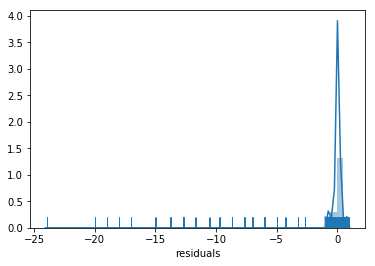

In [24]:
# residuals
lr_residuals = linearModel_cat.summary.residuals.toPandas()
sns.distplot(a=lr_residuals['residuals'], rug = True)

In [25]:
predictions_lr = linearModel_cat.transform(test_data)
predictions_lr.printSchema()

root
 |-- features: vector (nullable = true)
 |-- int_rate: integer (nullable = true)
 |-- prediction: double (nullable = false)



In [26]:
predictions_lr.toPandas().head(5)

,features,int_rate,prediction
0,"(0.9162907318741551, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,12.003979
1,"(1.0986122886681098, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,11.998712
2,"(1.2809338454620642, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,12.002697
3,"(1.2809338454620642, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,11.998070
4,"(1.2809338454620642, 36.0, 1.0, 0.0, 0.0, 0.0,...",12,11.997278


In [27]:
evaluator = RegressionEvaluator(metricName="r2",labelCol='int_rate')

In [28]:
evaluator.evaluate(predictions_lr)

0.9943948372187544